In [1]:
import os.path

import gpytorch
import latextable
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from func_algorithms import *
from func_data_generation import *
from func_polygon import *
from matplotlib import font_manager
from matplotlib.gridspec import GridSpec
from texttable import Texttable
from torch import nn
from torchsummary import summary
from utils import *
from warp_units import *

dtype = torch.double
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

torch.set_default_dtype(dtype)
%matplotlib inline
%load_ext autoreload
%autoreload 2

Using cuda device


## 几种方法进行空间推理的对比图


In [2]:
data_num = 1
sensor_num = 500  # [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

# load data
coords, shadow, shadow_noise, train_X, train_y, idx = load_data(data_num, sensor_num)

In [3]:
# get results from different algorithms
predict_nn = k_nearest_neighbor(train_X, train_y, coords, 20)
predict_iwdnn = k_nearest_neighbor(train_X, train_y, coords, 20, weights="distance")
predict_ok_mean, predict_ok_var = ok(train_X, train_y, coords)
predict_uk_mean, predict_uk_var = uk(train_X, train_y, coords)

Saving figure radio_map_cn


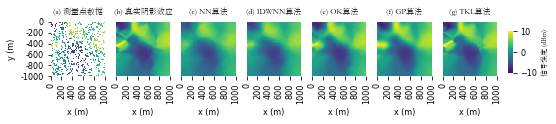

In [6]:
result_filename = DATA_PATH + "/result_" + str(data_num) + ".hd5f"
if os.path.exists(result_filename):
    with h5py.File(result_filename, "r") as f2:
        if "gp" in f2:
            if str(sensor_num) in f2["gp"]:
                predict_gp_mean = f2["/gp/" + str(sensor_num) + "/predict_mean"][...]
                predict_gp_var = f2["/gp/" + str(sensor_num) + "/predict_var"][...]

        if "dgp" in f2:
            if str(sensor_num) in f2["dgp"]:
                predict_dgp_mean = f2["/dgp/" + str(sensor_num) + "/predict_mean"][...]
                predict_dgp_var = f2["/dgp/" + str(sensor_num) + "/predict_var"][...]

        if "warpgp" in f2:
            if str(sensor_num) in f2["warpgp"]:
                predict_warpgp_mean = f2[
                    "/warpgp/" + str(sensor_num) + "/predict_mean"
                ][...]
                predict_warpgp_var = f2["/warpgp/" + str(sensor_num) + "/predict_var"][
                    ...
                ]
title_font = {
    "fontname": "STSong",
    "size": "8",
    "color": "black",
    "weight": "normal",
    "verticalalignment": "bottom",
}  # Bottom vertical alignment for more space
title_font_a = {
    "fontname": "STSong",
    "size": "7",
    "color": "black",
    "weight": "normal",
    "verticalalignment": "bottom",
}  # Bottom vertical alignment for more space
axis_font = {"fontname": "Arial", "size": "8"}
ticks_font = font_manager.FontProperties(
    family="Helvetica", style="normal", size=8, weight="normal", stretch="normal"
)

ticks_font_a = font_manager.FontProperties(
    family="Helvetica", style="normal", size=6, weight="normal", stretch="normal"
)
fig = plt.figure(figsize=(8, 1.8))
gs = GridSpec(1, 7, figure=fig)
ax_1 = fig.add_subplot(gs[0, 0])
ax_2 = fig.add_subplot(gs[0, 1])
ax_3 = fig.add_subplot(gs[0, 2])
ax_4 = fig.add_subplot(gs[0, 3])
ax_5 = fig.add_subplot(gs[0, 4])
ax_6 = fig.add_subplot(gs[0, 5])
ax_7 = fig.add_subplot(gs[0, 6])
axes = [ax_1, ax_2, ax_3, ax_4, ax_5, ax_6, ax_7]

cbar_ax = fig.add_axes([0.92, 0.32, 0.008, 0.32])
vmin = -10.0
vmax = 10.0
plot_heatmap(
    coords,
    shadow,
    ax=ax_2,
    #     vmin=-110,
    #     vmax=-80,
    vmin=vmin,
    vmax=vmax,
    #     robust=True,
)
plot_heatmap(coords, shadow_noise, ax=ax_1, vmin=vmin, vmax=vmax, mask_idx=idx)
plot_heatmap(
    coords,
    predict_nn,
    ax=ax_3,
    vmin=vmin,
    vmax=vmax,
)
plot_heatmap(
    coords,
    predict_iwdnn,
    ax=ax_4,
    vmin=vmin,
    vmax=vmax,
)
plot_heatmap(
    coords,
    predict_ok_mean,
    ax=ax_5,
    vmin=vmin,
    vmax=vmax,
)
plot_heatmap(
    coords,
    predict_gp_mean,
    ax=ax_6,
    vmin=vmin,
    vmax=vmax,
)
plot_heatmap(
    coords,
    predict_warpgp_mean,
    ax=ax_7,
    vmin=vmin,
    vmax=vmax,
    cbar=True,
    cbar_ax=cbar_ax,
)

# ax_1.set_xticks([])
# ax_1.set_xticks([], minor=True)
# ax_1.set_xlabel("")

# ax_3.set_xticks([])
# ax_3.set_xticks([], minor=True)
# ax_3.set_xlabel("")

# ax_5.set_xticks([])
# ax_5.set_xticks([], minor=True)
# ax_5.set_xlabel("")
for ax in axes[1:]:
    ax.set_yticks([])
    ax.set_yticks([], minor=True)
    ax.set_ylabel("")
    ax.set_xlabel("x (m)", **axis_font)
ax_1.set_xlabel("x (m)", **axis_font)
# ax_4.set_xlabel("x (m)", **axis_font)
# ax_6.set_xlabel("x (m)", **axis_font)
# ax_7.set_xlabel("x (m)", **axis_font)
# ax_1.set_ylabel("y (m)", **axis_font)
# ax_2.set_ylabel("y (m)", **axis_font)
ax_1.set_ylabel("y (m)", **axis_font)

ax_1.set_title("(a) 测量点数据", **title_font)
ax_2.set_title("(b) 真实阴影效应", **title_font)
ax_3.set_title("(c) NN算法", **title_font)
ax_4.set_title("(d) IDWNN算法", **title_font)
ax_5.set_title("(e) OK算法", **title_font)
ax_6.set_title("(f) GP算法", **title_font)
ax_7.set_title("(g) TKL算法", **title_font)

for ax in axes:
    for label in ax.get_xticklabels():
        label.set_fontproperties(ticks_font)
    for label in ax.get_yticklabels():
        label.set_fontproperties(ticks_font)
for label in cbar_ax.get_yticklabels():
    label.set_fontproperties(ticks_font)


cbar_ax.set_ylabel("信号强度 (dBm)", labelpad=12, **title_font_a)
save_fig("radio_map_cn", tight_layout=False, fig_extension="svg")

Saving figure radio_map_cn


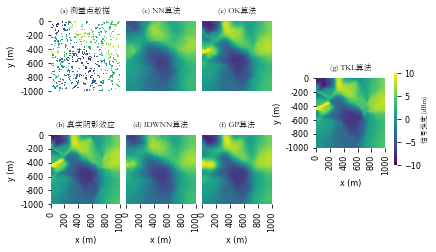

In [6]:
# 给中文文章的图

result_filename = DATA_PATH + "/result_" + str(data_num) + ".hd5f"
if os.path.exists(result_filename):
    with h5py.File(result_filename, "r") as f2:
        if "gp" in f2:
            if str(sensor_num) in f2["gp"]:
                predict_gp_mean = f2["/gp/" + str(sensor_num) + "/predict_mean"][...]
                predict_gp_var = f2["/gp/" + str(sensor_num) + "/predict_var"][...]

        if "dgp" in f2:
            if str(sensor_num) in f2["dgp"]:
                predict_dgp_mean = f2["/dgp/" + str(sensor_num) + "/predict_mean"][...]
                predict_dgp_var = f2["/dgp/" + str(sensor_num) + "/predict_var"][...]

        if "warpgp" in f2:
            if str(sensor_num) in f2["warpgp"]:
                predict_warpgp_mean = f2[
                    "/warpgp/" + str(sensor_num) + "/predict_mean"
                ][...]
                predict_warpgp_var = f2["/warpgp/" + str(sensor_num) + "/predict_var"][
                    ...
                ]
title_font = {
    "fontname": "STSong",
    "size": "8",
    "color": "black",
    "weight": "normal",
    "verticalalignment": "bottom",
}  # Bottom vertical alignment for more space
title_font_a = {
    "fontname": "STSong",
    "size": "7",
    "color": "black",
    "weight": "normal",
    "verticalalignment": "bottom",
}  # Bottom vertical alignment for more space
axis_font = {"fontname": "Arial", "size": "8"}
ticks_font = font_manager.FontProperties(
    family="Helvetica", style="normal", size=8, weight="normal", stretch="normal"
)

ticks_font_a = font_manager.FontProperties(
    family="Helvetica", style="normal", size=6, weight="normal", stretch="normal"
)
fig = plt.figure()
gs = GridSpec(4, 9, figure=fig)
ax_1 = fig.add_subplot(gs[0:2, 0:2])
ax_2 = fig.add_subplot(gs[2:, 0:2])
ax_3 = fig.add_subplot(gs[0:2, 2:4])
ax_4 = fig.add_subplot(gs[2:, 2:4])
ax_5 = fig.add_subplot(gs[0:2, 4:6])
ax_6 = fig.add_subplot(gs[2:, 4:6])
ax_7 = fig.add_subplot(gs[1:3, 7:])
axes = [ax_1, ax_2, ax_3, ax_4, ax_5, ax_6, ax_7]

cbar_ax = fig.add_axes([0.92, 0.32, 0.008, 0.32])
vmin = -10.0
vmax = 10.0
plot_heatmap(
    coords,
    shadow,
    ax=ax_2,
    #     vmin=-110,
    #     vmax=-80,
    vmin=vmin,
    vmax=vmax,
    #     robust=True,
)
plot_heatmap(coords, shadow_noise, ax=ax_1, vmin=vmin, vmax=vmax, mask_idx=idx)
plot_heatmap(
    coords,
    predict_nn,
    ax=ax_3,
    vmin=vmin,
    vmax=vmax,
)
plot_heatmap(
    coords,
    predict_iwdnn,
    ax=ax_4,
    vmin=vmin,
    vmax=vmax,
)
plot_heatmap(
    coords,
    predict_ok_mean,
    ax=ax_5,
    vmin=vmin,
    vmax=vmax,
)
plot_heatmap(
    coords,
    predict_gp_mean,
    ax=ax_6,
    vmin=vmin,
    vmax=vmax,
)
plot_heatmap(
    coords,
    predict_warpgp_mean,
    ax=ax_7,
    vmin=vmin,
    vmax=vmax,
    cbar=True,
    cbar_ax=cbar_ax,
)

ax_1.set_xticks([])
ax_1.set_xticks([], minor=True)
ax_1.set_xlabel("")
ax_1.set_ylabel("y (m)", **axis_font)

ax_2.set_xlabel("x (m)", **axis_font)
ax_2.set_ylabel("y (m)", **axis_font)

ax_3.set_xticks([])
ax_3.set_xticks([], minor=True)
ax_3.set_xlabel("")
ax_3.set_yticks([])
ax_3.set_yticks([], minor=True)
ax_3.set_ylabel("")

ax_4.set_xlabel("x (m)", **axis_font)
ax_4.set_yticks([])
ax_4.set_yticks([], minor=True)
ax_4.set_ylabel("")

ax_5.set_xticks([])
ax_5.set_xticks([], minor=True)
ax_5.set_xlabel("")
ax_5.set_yticks([])
ax_5.set_yticks([], minor=True)
ax_5.set_ylabel("")

ax_6.set_xlabel("x (m)", **axis_font)
ax_6.set_yticks([])
ax_6.set_yticks([], minor=True)
ax_6.set_ylabel("")

ax_7.set_xlabel("x (m)", **axis_font)
ax_7.set_ylabel("y (m)", **axis_font)


ax_1.set_title("(a) 测量点数据", **title_font)
ax_2.set_title("(b) 真实阴影效应", **title_font)
ax_3.set_title("(c) NN算法", **title_font)
ax_4.set_title("(d) IDWNN算法", **title_font)
ax_5.set_title("(e) OK算法", **title_font)
ax_6.set_title("(f) GP算法", **title_font)
ax_7.set_title("(g) TKL算法", **title_font)

for ax in axes:
    for label in ax.get_xticklabels():
        label.set_fontproperties(ticks_font)
    for label in ax.get_yticklabels():
        label.set_fontproperties(ticks_font)
for label in cbar_ax.get_yticklabels():
    label.set_fontproperties(ticks_font)


cbar_ax.set_ylabel("信号强度 (dBm)", labelpad=8, **title_font_a)
save_fig("radio_map_cn", tight_layout=False, fig_extension="svg")

In [7]:
def get_table(data_num, sensor_num):
    # load data
    data_filename = DATA_PATH + "/datasets_" + str(data_num) + ".hd5f"
    if os.path.exists(data_filename):
        with h5py.File(data_filename, "r") as f1:
            coords = f1["coords"][...]
            true_rss = f1["shadow"][...]
            observed_rss = f1["observed_rss"][...]
            train_X = f1["train_" + str(sensor_num) + "/train_X"][...]
            train_y = f1["train_" + str(sensor_num) + "/train_y"][...]
            idx = f1["train_" + str(sensor_num) + "/idx"][...]

    predict_nn = k_nearest_neighbor(train_X, train_y, coords, 20)
    predict_iwdnn = k_nearest_neighbor(train_X, train_y, coords, 20, weights="distance")
    predict_ok_mean, predict_ok_var = ok(train_X, train_y, coords)
    predict_uk_mean, predict_uk_var = uk(train_X, train_y, coords)

    predict_gp_mean = predict_dgp_mean = predict_warpgp_mean = None
    result_filename = DATA_PATH + "/result_" + str(data_num) + ".hd5f"
    if os.path.exists(result_filename):
        with h5py.File(result_filename, "r") as f2:
            if "gp" in f2:
                if str(sensor_num) in f2["gp"]:
                    predict_gp_mean = f2["/gp/" + str(sensor_num) + "/predict_mean"][
                        ...
                    ]
                    predict_gp_var = f2["/gp/" + str(sensor_num) + "/predict_var"][...]

            if "dgp" in f2:
                if str(sensor_num) in f2["dgp"]:
                    predict_dgp_mean = f2["/dgp/" + str(sensor_num) + "/predict_mean"][
                        ...
                    ]
                    predict_dgp_var = f2["/dgp/" + str(sensor_num) + "/predict_var"][
                        ...
                    ]

            if "warpgp" in f2:
                if str(sensor_num) in f2["warpgp"]:
                    predict_warpgp_mean = f2[
                        "/warpgp/" + str(sensor_num) + "/predict_mean"
                    ][...]
                    predict_warpgp_var = f2[
                        "/warpgp/" + str(sensor_num) + "/predict_var"
                    ][...]
    table = Texttable()
    table.set_cols_align(["c", "c", "c", "c"])
    table.set_cols_dtype(["t", "f", "f", "f"])
    table.set_precision(4)
    table.add_rows(
        [
            ["Algorithm", "MAPE", "RMSE", "CRPS"],
            [
                "Nearest Neighbor",
                MAPE(true_rss, predict_nn, idx),
                RMSE(true_rss, predict_nn, idx),
                "None",
            ],
            [
                "IDW Nearest Neighbor",
                MAPE(true_rss, predict_iwdnn, idx),
                RMSE(true_rss, predict_iwdnn, idx),
                "None",
            ],
            [
                "Ordinary Kriging",
                MAPE(true_rss, predict_ok_mean, idx),
                RMSE(true_rss, predict_ok_mean, idx),
                CRPS(true_rss, predict_ok_mean, predict_ok_var, idx),
            ],
        ]
    )

    if predict_gp_mean is not None:
        table.add_row(
            [
                "Gaussian Process",
                MAPE(true_rss, predict_gp_mean, idx),
                RMSE(true_rss, predict_gp_mean, idx),
                CRPS(true_rss, predict_gp_mean, predict_gp_var, idx),
            ]
        )

    if predict_dgp_mean is not None:
        table.add_row(
            [
                "Deep Kernel Gaussian Process",
                MAPE(true_rss, predict_dgp_mean, idx),
                RMSE(true_rss, predict_dgp_mean, idx),
                CRPS(true_rss, predict_dgp_mean, predict_dgp_var, idx),
            ]
        )

    if predict_warpgp_mean is not None:
        table.add_row(
            [
                "Spatial Warp Gaussian Process",
                MAPE(true_rss, predict_warpgp_mean, idx),
                RMSE(true_rss, predict_warpgp_mean, idx),
                CRPS(true_rss, predict_warpgp_mean, predict_warpgp_var, idx),
            ]
        )
    return table

In [8]:
table = get_table(data_num=1, sensor_num=1000)
print(table.draw())

+-------------------------------+--------+--------+--------+
|           Algorithm           |  MAPE  |  RMSE  |  CRPS  |
+===============================+========+========+========+
|       Nearest Neighbor        | 1.0412 | 1.1030 |  None  |
+-------------------------------+--------+--------+--------+
|     IDW Nearest Neighbor      | 0.7922 | 0.8693 |  None  |
+-------------------------------+--------+--------+--------+
|       Ordinary Kriging        | 0.3050 | 0.3593 | 0.3333 |
+-------------------------------+--------+--------+--------+
|       Gaussian Process        | 0.4157 | 0.3962 | 0.1926 |
+-------------------------------+--------+--------+--------+
| Spatial Warp Gaussian Process | 0.3647 | 0.3355 | 0.1447 |
+-------------------------------+--------+--------+--------+


In [9]:
print(
    latextable.draw_latex(table, caption="Another table.", label="table:another_table")
    + "\n"
)

\begin{table}
	\begin{center}
		\begin{tabular}{|c|c|c|c|}
			\hline
			Algorithm & MAPE & RMSE & CRPS \\
			\hline
			Nearest Neighbor & 1.0412 & 1.1030 & None \\
			\hline
			IDW Nearest Neighbor & 0.7922 & 0.8693 & None \\
			\hline
			Ordinary Kriging & 0.3050 & 0.3593 & 0.3333 \\
			\hline
			Gaussian Process & 0.4157 & 0.3962 & 0.1926 \\
			\hline
			Spatial Warp Gaussian Process & 0.3647 & 0.3355 & 0.1447 \\
			\hline
		\end{tabular}
	\end{center}
	\caption{Another table.}
	\label{table:another_table}
\end{table}



In [10]:
def get_rmse(data_num, sensor_nums):

    data_filename = DATA_PATH + "/datasets_" + str(data_num) + ".hd5f"

    if os.path.exists(data_filename):
        with h5py.File(data_filename, "r") as f1:
            coords = f1["coords"][...]
            true_rss = f1["shadow"][...]
            observed_rss = f1["observed_rss"][...]
    length = len(sensor_nums)
    nn_rmse = np.zeros((length))
    idwnn_rmse = np.zeros((length))
    ok_rmse = np.zeros((length))
    gp_rmse = np.zeros((length))
    warpgp_rmse = np.zeros((length))

    for i, num in enumerate(sensor_nums):
        with h5py.File(data_filename, "r") as f1:
            train_X = f1["train_" + str(num) + "/train_X"][...]
            train_y = f1["train_" + str(num) + "/train_y"][...]
            idx = f1["train_" + str(num) + "/idx"][...]
        predict_nn = k_nearest_neighbor(train_X, train_y, coords, 20)
        predict_idwnn = k_nearest_neighbor(
            train_X, train_y, coords, 20, weights="distance"
        )
        predict_ok_mean, predict_ok_var = ok(train_X, train_y, coords)

        if os.path.exists(result_filename):
            with h5py.File(result_filename, "r") as f2:
                if "gp" in f2:
                    if str(num) in f2["gp"]:
                        predict_gp_mean = f2["/gp/" + str(num) + "/predict_mean"][...]
                        predict_gp_var = f2["/gp/" + str(num) + "/predict_var"][...]

                if "dgp" in f2:
                    if str(num) in f2["dgp"]:
                        predict_dgp_mean = f2["/dgp/" + str(num) + "/predict_mean"][...]
                        predict_dgp_var = f2["/dgp/" + str(num) + "/predict_var"][...]

                if "warpgp" in f2:
                    if str(num) in f2["warpgp"]:
                        predict_warpgp_mean = f2[
                            "/warpgp/" + str(num) + "/predict_mean"
                        ][...]
                        predict_warpgp_var = f2["/warpgp/" + str(num) + "/predict_var"][
                            ...
                        ]

        nn_rmse[i] = RMSE(true_rss, predict_nn, idx)
        idwnn_rmse[i] = RMSE(true_rss, predict_idwnn, idx)
        ok_rmse[i] = RMSE(true_rss, predict_ok_mean, idx)
        gp_rmse[i] = RMSE(true_rss, predict_gp_mean, idx)
        warpgp_rmse[i] = RMSE(true_rss, predict_warpgp_mean, idx)
    return nn_rmse, idwnn_rmse, ok_rmse, gp_rmse, warpgp_rmse, sensor_nums

In [11]:
def get_crps(data_num, sensor_nums):

    data_filename = DATA_PATH + "/datasets_" + str(data_num) + ".hd5f"

    if os.path.exists(data_filename):
        with h5py.File(data_filename, "r") as f1:
            coords = f1["coords"][...]
            true_rss = f1["shadow"][...]
            observed_rss = f1["observed_rss"][...]
    length = len(sensor_nums)
    ok_crps = np.zeros((length))
    gp_crps = np.zeros((length))
    warpgp_crps = np.zeros((length))

    for i, num in enumerate(sensor_nums):
        with h5py.File(data_filename, "r") as f1:
            train_X = f1["train_" + str(num) + "/train_X"][...]
            train_y = f1["train_" + str(num) + "/train_y"][...]
            idx = f1["train_" + str(num) + "/idx"][...]
        predict_ok_mean, predict_ok_var = ok(train_X, train_y, coords)

        if os.path.exists(result_filename):
            with h5py.File(result_filename, "r") as f2:
                if "gp" in f2:
                    if str(num) in f2["gp"]:
                        predict_gp_mean = f2["/gp/" + str(num) + "/predict_mean"][...]
                        predict_gp_var = f2["/gp/" + str(num) + "/predict_var"][...]

                if "dgp" in f2:
                    if str(num) in f2["dgp"]:
                        predict_dgp_mean = f2["/dgp/" + str(num) + "/predict_mean"][...]
                        predict_dgp_var = f2["/dgp/" + str(num) + "/predict_var"][...]

                if "warpgp" in f2:
                    if str(num) in f2["warpgp"]:
                        predict_warpgp_mean = f2[
                            "/warpgp/" + str(num) + "/predict_mean"
                        ][...]
                        predict_warpgp_var = f2["/warpgp/" + str(num) + "/predict_var"][
                            ...
                        ]

        ok_crps[i] = CRPS(true_rss, predict_ok_mean, predict_ok_var, idx)
        gp_crps[i] = CRPS(true_rss, predict_gp_mean, predict_gp_var, idx)
        warpgp_crps[i] = CRPS(true_rss, predict_warpgp_mean, predict_warpgp_var, idx)
    return ok_crps, gp_crps, warpgp_crps, sensor_nums

In [12]:
def plot_rmse(nn, idwnn, ok, gp, tkgp, sensor_nums):
    with plt.style.context(["science", "ieee", "no-latex", "grid"]):
        figure, ax = plt.subplots()
        ax.plot(
            sensor_nums,
            nn,
            label="NN",
            ls="-",
            marker="x",
            c="b",
            linewidth=0.5,
            markersize=3,
        )
        ax.plot(
            sensor_nums,
            idwnn,
            label="IDWNN",
            ls=":",
            marker="+",
            c="g",
            linewidth=0.5,
            markersize=3,
        )
        ax.plot(
            sensor_nums,
            ok,
            label="OK",
            ls="-.",
            marker="o",
            c="c",
            linewidth=0.5,
            markersize=2,
            markerfacecolor="None",
        )
        ax.plot(
            sensor_nums,
            gp,
            label="GP",
            ls="--",
            marker="s",
            c="m",
            linewidth=0.5,
            markersize=2,
            markerfacecolor="None",
        )
        ax.plot(
            sensor_nums,
            tkgp,
            label="TKL",
            ls="-",
            marker="v",
            c="r",
            linewidth=0.5,
            markersize=2,
            markerfacecolor="None",
        )
        #         ax.plot(sensor_nums, nn_mape, marker=".", label="NN")
        #         ax.plot(sensor_nums, idwnn_mape, marker="s", label="IWD NN")
        #         ax.plot(sensor_nums, ok_mape, marker="x", label="OK")
        ax.set_xlabel("群智感知设备数量", font="STSong")
        ax.set_ylabel("均方根误差", font="STSong")
        ax.legend(fontsize=6, labelspacing=0.25)

In [18]:
def plot_crps(ok, gp, tkgp, sensor_nums):
    with plt.style.context(["science", "ieee", "no-latex", "grid"]):
        figure, ax = plt.subplots()
        ax.plot(
            sensor_nums,
            ok,
            label="OK",
            ls="-.",
            marker="o",
            c="c",
            linewidth=0.5,
            markersize=2,
            markerfacecolor="None",
        )
        ax.plot(
            sensor_nums,
            gp,
            label="GP",
            ls="--",
            marker="s",
            c="m",
            linewidth=0.5,
            markersize=2,
            markerfacecolor="None",
        )
        ax.plot(
            sensor_nums,
            tkgp,
            label="TKL",
            ls="-",
            marker="v",
            c="r",
            linewidth=0.5,
            markersize=2,
            markerfacecolor="None",
        )
        #         ax.plot(sensor_nums, nn_mape, marker=".", label="NN")
        #         ax.plot(sensor_nums, idwnn_mape, marker="s", label="IWD NN")
        #         ax.plot(sensor_nums, ok_mape, marker="x", label="OK")
        ax.set_xlabel("群智感知设备数量", font="STSong")
        ax.set_ylabel("连续分级概率评分", font="STSong")
        ax.legend(fontsize=6, labelspacing=0.25)

In [14]:
nn_rmse, idwnn_rmse, ok_rmse, gp_rmse, tkl_rmse, sensor_nums = get_rmse(
    1, range(200, 801, 50)
)

Saving figure rmse_comparison_cn


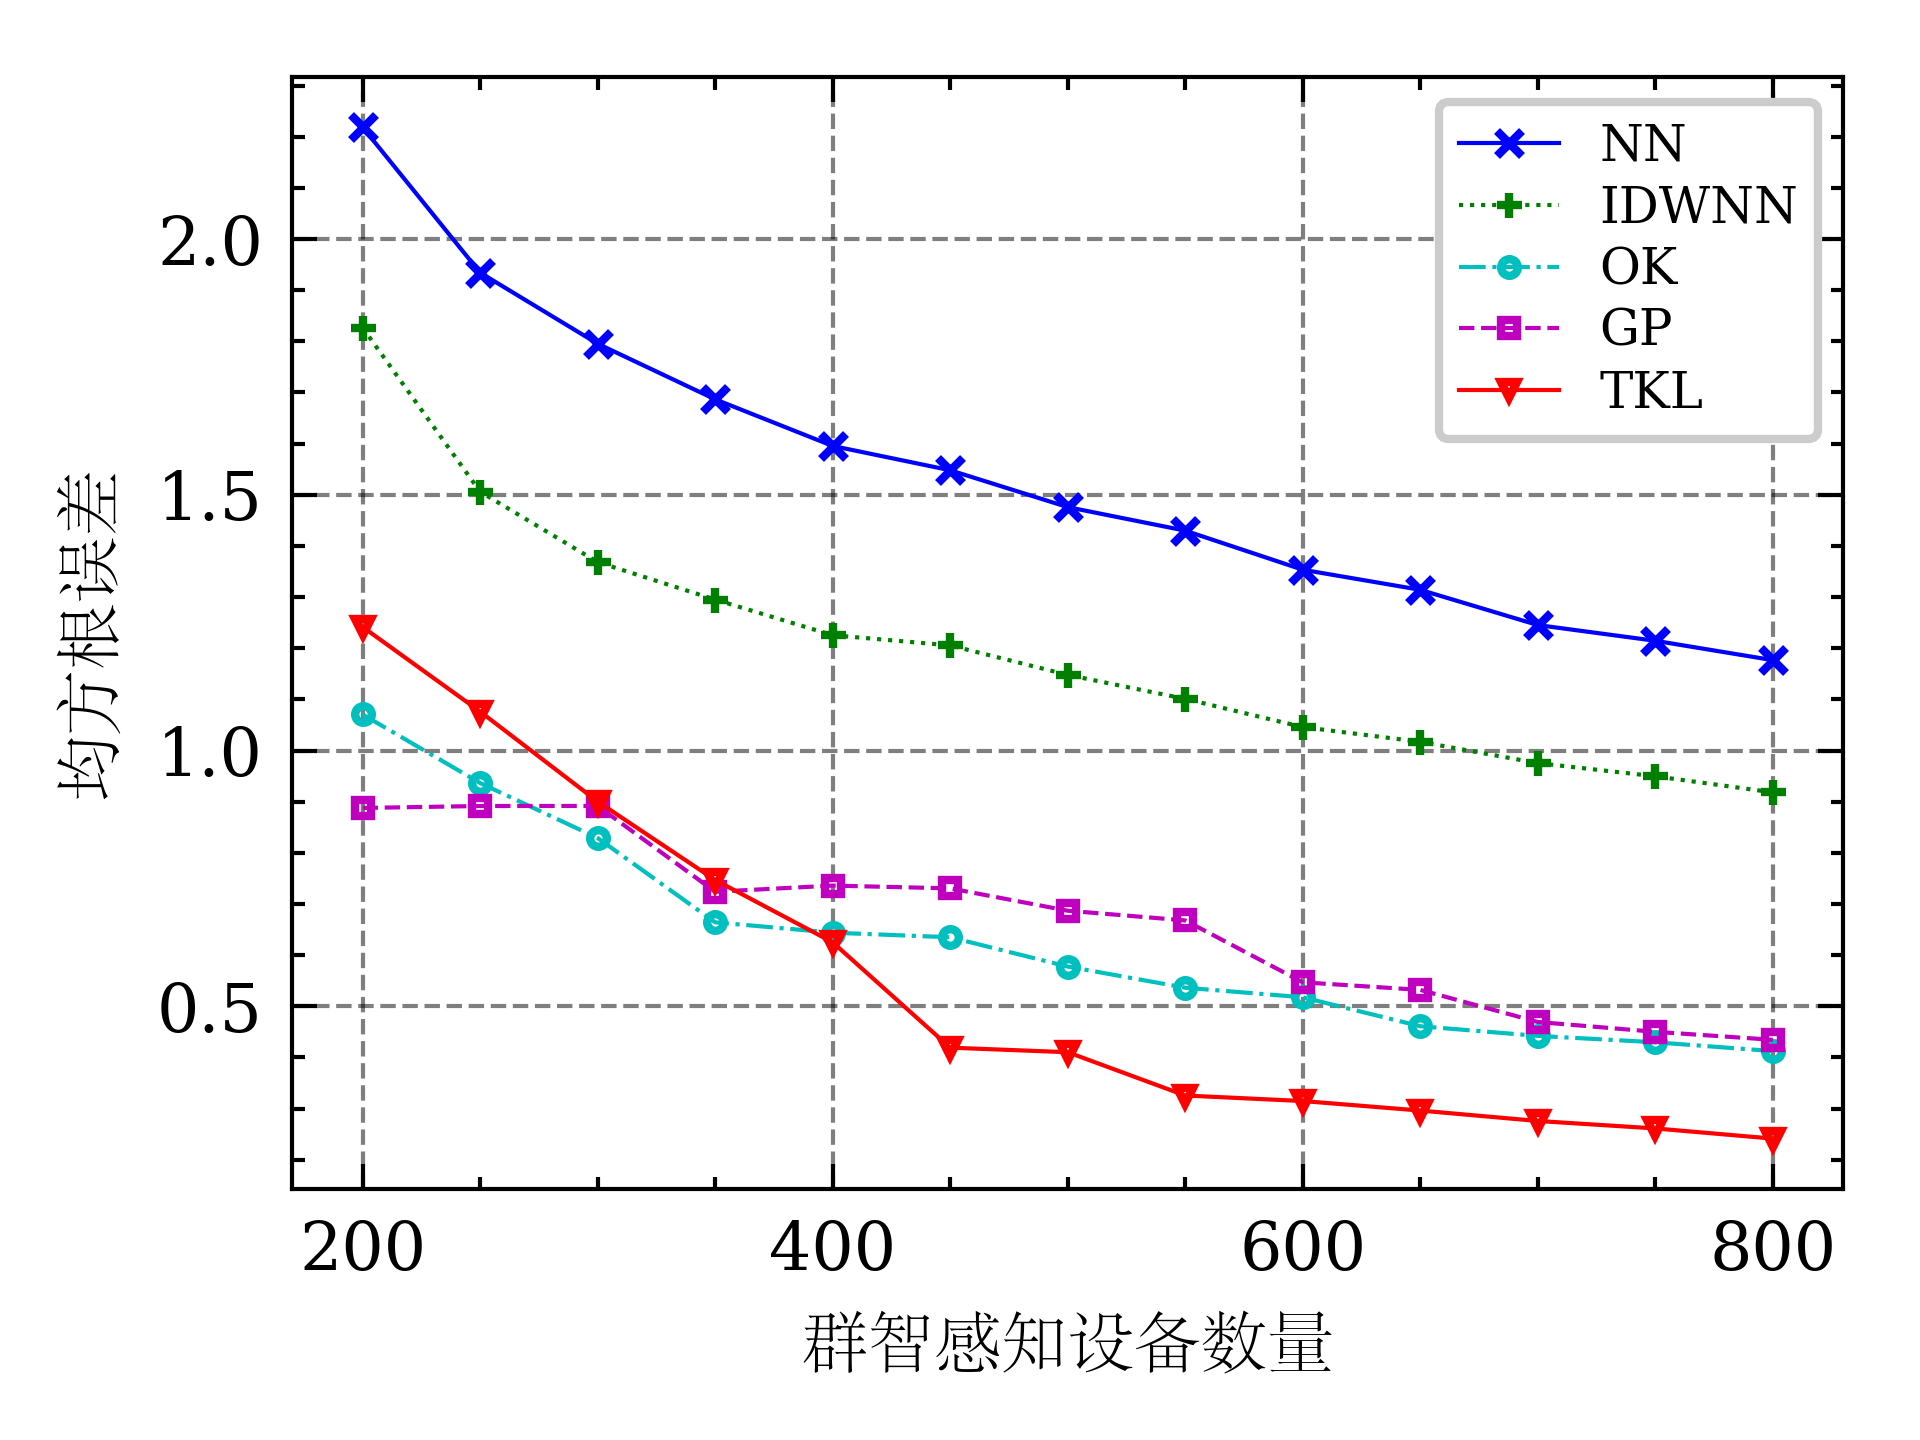

In [15]:
plot_rmse(nn_rmse, idwnn_rmse, ok_rmse, gp_rmse, tkl_rmse, sensor_nums)
save_fig("rmse_comparison_cn", fig_extension="svg")

In [19]:
ok_crps, gp_crps, tkl_crps, sensor_nums = get_crps(1, range(200, 801, 50))

Saving figure crps_comparison_cn


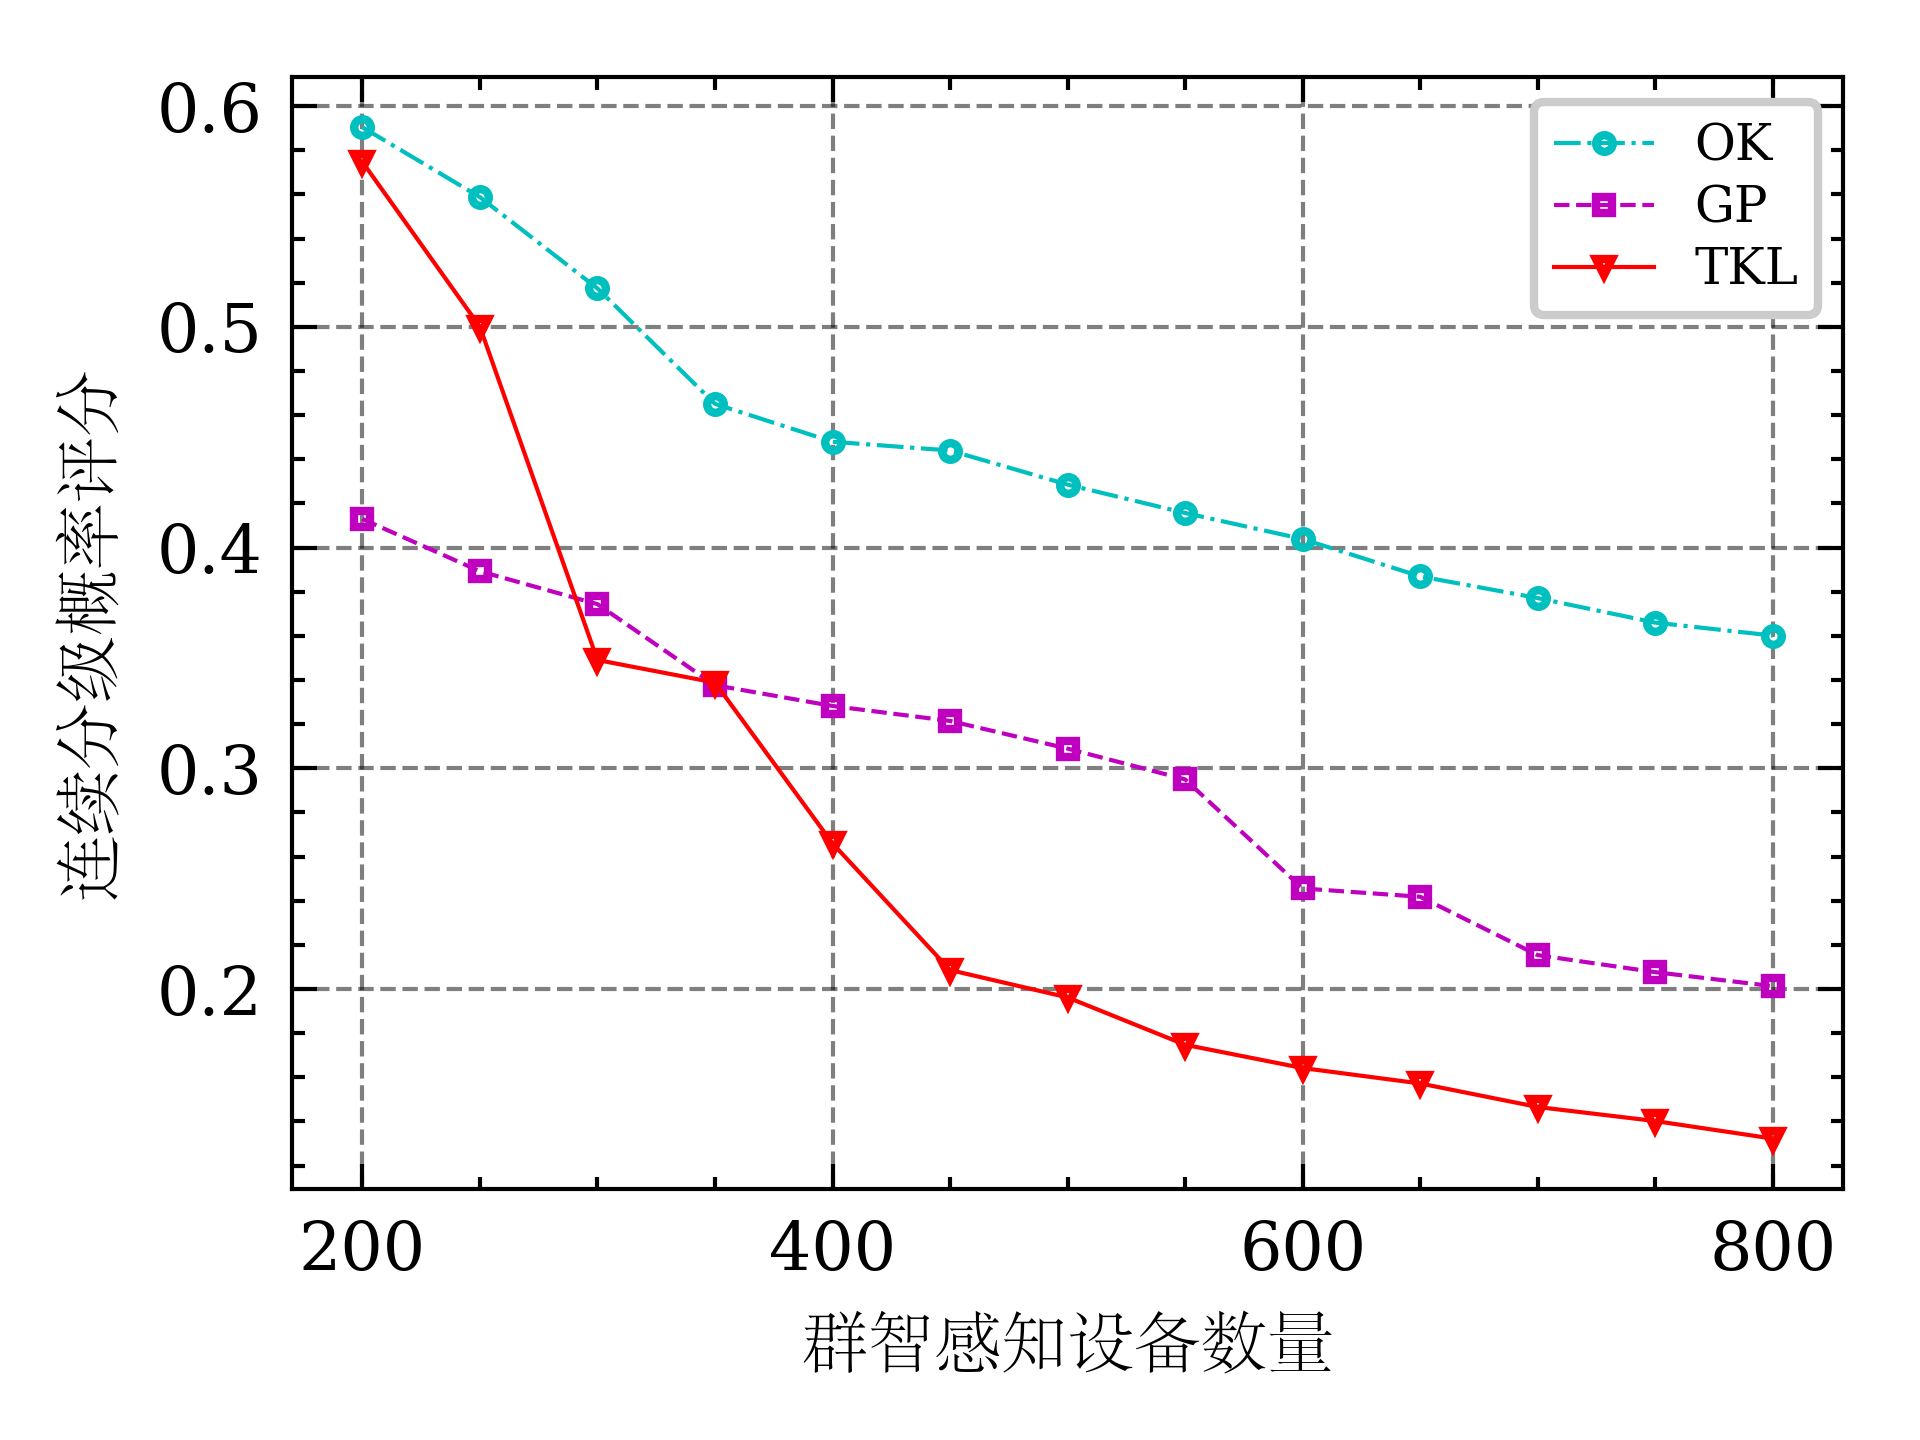

In [20]:
plot_crps(ok_crps, gp_crps, tkl_crps, sensor_nums)
save_fig("crps_comparison_cn", fig_extension="svg")

In [33]:
sensor_num = np.array(list(range(50, 501, 50)))

In [34]:
sensor_num

array([ 50, 100, 150, 200, 250, 300, 350, 400, 450, 500])